In [1]:
# import cell

import xarray as xr # to work with multi-dimensional arrays
import numpy as np # to work with multi-dimensional arrays
import regionmask # to work with predefined data masks
import pandas as pd # to work with tables
import xesmf as xe # to regrid data
import glob # to find file pathways
import netCDF4 # use to save xarrays as nc files
import matplotlib
import matplotlib.pyplot as plt # for plotting
import matplotlib.colors as colors # for custom colourbars
import cartopy # use for geographic map projections
import cartopy.crs as ccrs # use for geographic map projections
import time # to add a creation timestamp to Datasets
import pickle # to save DataFrame objects efficiently
import math # perform select mathematical operations
import datetime

### Anomaly to Absolute Values Conversion: CRUTEM4 Dataset

As only CRUTEM4 gridded anomaly data and baseline data is availble, both will be used to reconstruct the original absolute data.

In [43]:
# load near surface temperature anomaly data from CRUTEM4 observational dataset
crutem4_anom_pw = '/home/ucfagtj/DATA/Dissertation/Data/observations/CRUTEM4_anomalies.nc'
crutem4_anom_ds = xr.open_dataset(crutem4_anom_pw, use_cftime = True)
crutem4_anom_ds = crutem4_anom_ds.sel(time = slice('1981', '2010')) # restrict to present day period

# load baseline values used to calculate CRUTEM4 anomalies
crutem4_bl_pw = '/home/ucfagtj/DATA/Dissertation/Data/observations/CRUTEM4_baseline_period.nc'
crutem4_bl_ds = xr.open_dataset(crutem4_bl_pw)

# create a copy of CRUTEM4 observational dataset to convert to absolute values
crutem4_abso_ds = crutem4_anom_ds.temperature_anomaly.copy()
crutem4_abso_ds = crutem4_abso_ds.rename({'latitude': 'lat',  # rename coordinates to match baseline data
                                          'longitude': 'lon'}) 

# group each monthly DataArray in terms of months; all Jans in one Dataset object etc.
month_indices = crutem4_abso_ds.groupby('time.month').groups # provides indices of data falling in each motnh

for i, month_idxs in enumerate(month_indices.values()):
    
    # define the baseline for given month
    month_bl = crutem4_bl_ds.tem.sel(time = i + 1) # index starts at 0; first month is 1
    
    # add monthly baseline to corresponding monthly anomalies to convert back to absolute values
    x = crutem4_abso_ds.isel(time = month_idxs) + month_bl # selects only the indices for a given month
    
    # concatenate the absolute DataArray with other months; unless Jan in which create the object
    if i > 0:
        absolute_values = xr.concat([absolute_values, x], dim = 'time') 
    elif i == 0:
        absolute_values = x
    
    # close open Dataset and/or DataArray objects
    x.close(), month_bl.close()

# sort absolute observational data by time
absolute_values = absolute_values.sortby('time')

# define some attributes for the Dataset object
obs_ds = xr.Dataset({'crutem4_obs_abso': absolute_values})
obs_ds.attrs['title'] = 'near surface temperature observational dataset (CRUTEM4)'
obs_ds.attrs['period'], obs_ds.attrs['created_on'] = '1981-2010', time.ctime()
obs_ds.attrs['units'] = 'degrees Celcius'

# save Dataset object
save_pw = '/home/ucfagtj/DATA/Dissertation/Data/observations/CRUTEM4_tas_1981-2010_absolute_values.nc'
obs_ds.to_netcdf(save_pw, 'w')
print(f'File saved: {save_pw.split("/")[-1]}')

# close open Dataset and/or DataArray objects
crutem4_anom_ds.close(), crutem4_abso_ds.close(), crutem4_bl_ds.close(), 
obs_ds.close(), absolute_values.close()

File saved: CRUTEM4_tas_1981-2010_absolute_values.nc


(None, None)

### Observation Near Surface Temperature CRUTEM4 Dataset Anomaly: All Models

Compute the modelled average annual near surface temperature anomaly relative to the average annual value of the observational CRUTEMN4 dataset for each cell across the present day period. Computation will be carried out on 5.0 x 5.0 latitude-longtiude grid.

In [2]:
# load annual near surface temperature observation dataset
obs_pw = '/home/ucfagtj/DATA/Dissertation/Data/observations/CRUTEM4_tas_1981-2010_absolute_values.nc'
obs_ds = xr.open_dataset(obs_pw, use_cftime = True)

# define pathays of modelled current absolute annual near surface temperature; 5x5 latitude-longtiude grid
f_pws = glob.glob('/home/ucfagtj/DATA/Dissertation/Data/Temperature/Annual/current/*/*/*ann_tas*5x5_res*')

# create Dataset object to store all the model observational anomalies
obs_anom_ds = xr.Dataset()
models = [] # create a list to store the model names of those in Dataset

# compute the average annual near surface temperature of the observations
obs_ds = obs_ds.groupby('time.year').mean(skipna = True) # each annual average near surface temperature 
obs_ds = obs_ds.mean(dim = 'year', skipna = True)# average annual average near surface temperature

# compute each model's observational anomalies
for pw in f_pws:
    
    # laod in model output; current mean annual near surface temperature
    x = xr.open_dataset(pw)
    model_data = x.mean_tas
   
    # note the model used in each iteration
    model_name = x.model
    models += [model_name] # add model to list of models used
    x.close()
    
    # negate observations from model output
    obs_anom_ds[f'{model_name}_HadEX2_anom'] = model_data - obs_ds.crutem4_obs_abso
         
    # close open Dataset and/or DataArray objects
    model_data.close()

# add attribute information
obs_anom_ds.attrs['description'] = 'annual near surface temperature anomaly relative to' + \
                                   ' CRUTEM4 annual near surface temperature observations'
obs_anom_ds.attrs['period'], obs_anom_ds.attrs['years_sampled'] = '1981-2010', '30'
obs_anom_ds.attrs['models_used'], obs_anom_ds.attrs['created_on'] = models, time.ctime()
obs_anom_ds.attrs['resolution'] = 'latxlon: 5x5 degrees'

# save Dataset object
save_pw = '/home/ucfagtj/DATA/Dissertation/Data/observations/all_models_tas_observational_anomaly.nc'
obs_anom_ds.to_netcdf(save_pw, 'w')
print(f'File saved: {save_pw.split("/")[-1]}')

obs_ds.close(), obs_anom_ds.close()

/home/ucfagtj/.conda/envs/geog0121/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


File saved: all_models_tas_observational_anomaly.nc


(None, None)

### Observation Near Surface Temperature CRUTEM4 Dataset Anomaly: Multi-Model Ensemble

The observational anomaly is computed by negating the model output from the regridded observation dataset. Only the present day (1981-2010) anomaly can be calculated as observational datasets do not cover the pre-industrial period (1851-1900).

In [79]:
# load in CRUTEM4 and multi-model ensemble near surface temperature data; 5x5 resolution
obs_pw = '/home/ucfagtj/DATA/Dissertation/Data/observations/CRUTEM4_tas_1981-2010_absolute_values.nc'
ens_pw = '/home/ucfagtj/DATA/Dissertation/Data/Temperature/processed/ensemble_tas_5x5_res.nc'
obs_ds = xr.open_dataset(obs_pw)
ens_ds = xr.open_dataset(ens_pw).current_mean_ann_tas_abso # only comparing to current period

# compute the average annual near surface temperature of the observations
obs_ds = obs_ds.groupby('time.year').mean(skipna = True) # each annual average near surface temperature 
obs_ds = obs_ds.mean(dim = 'year', skipna = True)# average annual average near surface temperature

# create Dataset object to store the annual near surface temperature anomaly relative to observations
obs_anom_ds = xr.Dataset()

# compute the differences between ensemble mean and obersvation mean annual near surface temperature
obs_anom_ds['ens_crutem4_anom'] = ens_ds - obs_ds.crutem4_obs_abso

# add attribute information
obs_anom_ds.attrs['description'] = 'mulit-model ensemble near surface temperature anomaly relative to' + \
                                   ' observational derived annual near surface temperature'
obs_anom_ds.attrs['period'], obs_anom_ds.attrs['years_sampled'] = '1981-2010', '30'
obs_anom_ds.attrs['resolution'], obs_anom_ds.attrs['created_on'] = '5deg_x_5deg', time.ctime()

# save Dataset object
save_pw = '/home/ucfagtj/DATA/Dissertation/Data/observations/ensemble_tas_observation_anomaly.nc'
obs_anom_ds.to_netcdf(save_pw, 'w')
print(f'File saved: {save_pw.split("/")[-1]}')

# close open Dataset and DataArray objects
ens_ds.close(), obs_ds.close(), obs_anom_ds.close()

File saved: ensemble_tas_observation_anomaly.nc


/home/ucfagtj/.conda/envs/geog0121/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


(None, None, None)

### Obeservational Anomalies: All Models

The observational anomaly is computed by negating the model output from the regridded observation dataset. Only the present day (1981-2010) anomaly can be calculated as observational datasets do not cover the pre-industrial period (1851-1900).

In [54]:
# load in CRUTEM4 near surface temperature data; 1x1 resolution
obs_pw = '/home/ucfagtj/DATA/Dissertation/Data/observations/CRUTEM4_mean_ann_tas_1981-2010_1x1_res.nc'
obs_ds = xr.open_dataset(obs_pw).crutem4_obs

# define the pathways to each model's current absolute near surface temperature data; 1x1 resolution
f_pws = glob.glob('/home/ucfagtj/DATA/Dissertation/Data/Temperature/Annual/current/*/*/' + \
                  '*ann_tas*1x1_res*')

# create Dataset object to store all the model observational anomalies
obs_anom_ds = xr.Dataset()
models = [] # create a list to store the model names of those in Dataset

# compute each model's observational anomalies
for pw in f_pws:
    
    # laod in model output; current mean annual near surface temperature only
    x = xr.open_dataset(pw)
    model_data = x.mean_tas
    
    # note the model used in each iteration
    model_name = x.model
    models += [model_name] # add model to list of models used
    x.close()
    
    # negate observations from model output
    obs_anom_ds[f'{model_name}_crutem4_anom'] = model_data - obs_ds
         
    # close open Dataset and/or DataArray objects
    model_data.close()

# add attribute information
obs_anom_ds.attrs['description'] = 'annual near surface temperature anomaly relative to' + \
                                   ' observational derived annual near surface temperature'
obs_anom_ds.attrs['period'], obs_anom_ds.attrs['years_sampled'] = '1981-2010', '30'
obs_anom_ds.attrs['resolution'], obs_anom_ds.attrs['created_on'] = '1deg_x_1deg', time.ctime()
obs_anom_ds.attrs['models_used'] = models
obs_anom_ds.attrs['regridding_method'] = 'both model output and observation dataset use bilinear' + \
                                         ' interpolation'
 
# save Dataset object
save_pw = '/home/ucfagtj/DATA/Dissertation/Data/observations/all_models_tas_observation_anomaly.nc'
obs_anom_ds.to_netcdf(save_pw, 'w')
print(f'File saved: {save_pw.split("/")[-1]}')
    
# close open Dataset and/or DataArray objects
obs_ds.close(), obs_anom_ds.close()

File saved: all_models_tas_observation_anomaly.nc


(None, None)

### Root Mean Square Error (RMSE)


Metacode:


In [81]:
# load annual near surface temperature observation dataset
obs_pw = '/home/ucfagtj/DATA/Dissertation/Data/observations/CRUTEM4_tas_1981-2010_absolute_values.nc'
obs_ds = xr.open_dataset(obs_pw, use_cftime = True)

# compute the average annual near surface temperature of the observations
obs_ds = obs_ds.groupby('time.year').mean(skipna = True) # each annual average near surface temperature 
obs_ds = obs_ds.mean(dim = 'year', skipna = True)# average annual average near surface temperature

# define pathays of modelled current absolute annual near surface temperature; 5x5 latitude-longtiude grid
f_pws = glob.glob('/home/ucfagtj/DATA/Dissertation/Data/Temperature/Annual/current/*/*/*ann_tas*5x5_res*')

# create a list to store the model names of those in Dataset
models = [] 

# define a land mask to restrict RMSE compuation to land cells only
lon, lat = np.arange(-177.5, 182.5, 5.), np.arange(-87.5, 92.5, 5.)
land_mask = regionmask.defined_regions.natural_earth.land_110.mask(lon, lat)


###### compute the absolute RMSE of all individual models ######


# define a dictionary object to store model RMSEs in
rmse_dict = dict()

# compute each model's RMSE
for pw in f_pws:
    
    # laod in model output; current mean annual near surface temperature for land area only
    x = xr.open_dataset(pw)
    model_data = x.mean_tas.where(land_mask == 0)
    
    # note the model used in each iteration
    model_name = x.model
    models += [model_name] # add model to list of models used
    x.close()
    
    # compute the resdiual of each grid cell; data on same grid so can simply negate
    residual = model_data - obs_ds.crutem4_obs_abso
    
    # compute the squared error of each grid cell
    sq_err = residual**2
    
    # compute the spatial mean of the squared error over land; cell comparison; no need for latitude weighting
    mean_sq_err = sq_err.mean(skipna = True)
    
    # determine the root of the mean squared error to obtain the RMSE
    model_rmse = math.sqrt(mean_sq_err.values)
    
    # add the model and associated RMSE value to dictionary object
    rmse_dict[f'{model_name}'] = model_rmse
    
    # close open Dataset and/or DataArray objects
    model_data.close(), sq_err.close(), mean_sq_err.close()
    
# determine the median model RMSE and add value to dictionary object
rmse_arr = np.array(list(rmse_dict.values())) # dictionary values to list then to numpy array
rmse_median = np.median(rmse_arr, axis = 0)
rmse_dict['median'] = rmse_median # median exclude the multi-model rmse value


###### compute the absolute RMSE of the multi-model ensemble ######


# load in nulit-model ensemble output; current mean tropical nights only
ens_pw = '/home/ucfagtj/DATA/Dissertation/Data/Temperature/processed/ensemble_tas_5x5_res.nc'
ens_ds = xr.open_dataset(ens_pw).current_mean_ann_tas_abso

# compute the multi-model ensemble RMSE
residuals = ens_ds - obs_ds.crutem4_obs_abso # compute residuals
sq_err = residuals**2
mean_sq_err = sq_err.mean(skipna = True)
ens_rmse = math.sqrt(mean_sq_err.values)

# add multi-model ensemble RMSE to dictionary object
rmse_dict['ensemble'] = ens_rmse

# close open Dataset and/or DataArray objects
obs_ds.close(), residual.close(), sq_err.close(), mean_sq_err.close()


###### compute the relative RMSE of all models and multi-model ensemble ######


# define a dictionary object to store model relative RMSEs in
rel_rmse_dict = dict()

# compute the relative RMSE values for each model
models += ['ensemble'] # add ensemble key to list of model names
for model in models:
    rel_rmse = (rmse_dict[f'{model}'] - rmse_dict['median']) / rmse_dict['median']
    
    # add relative RMSE value to dictionary object
    rel_rmse_dict[f'{model}'] = rel_rmse
    
print(rmse_dict, rel_rmse_dict)


###### save both RMSE dictionary objects ######
    
    
# save dictionary objects using pickle module (serialisation)
abso_save_pw = '/home/ucfagtj/DATA/Dissertation/Data/observations/rmse_tas_dictionary.pkl'
rel_save_pw = '/home/ucfagtj/DATA/Dissertation/Data/observations/rel_rmse_tas_dictionary.pkl'
with open(abso_save_pw, 'wb') as f:
    pickle.dump(rmse_dict, f)
with open(rel_save_pw, 'wb') as f:
    pickle.dump(rel_rmse_dict, f)
    
# warning just stating that a mean of only NaN values has been taken at some stage

/home/ucfagtj/.conda/envs/geog0121/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


{'AWI-CM-1-1-MR': 2.1988129987075475, 'CanESM5': 2.233056649612294, 'ACCESS-ESM1-5': 1.8547855601253234, 'MPI-ESM1-2-HR': 2.066410146345107, 'INM-CM5-0': 1.9376300562643753, 'INM-CM4-8': 1.974621185578098, 'MIROC6': 3.2315779012071237, 'MRI-ESM2-0': 2.102030739789262, 'GFDL-ESM4': 2.2802994536030092, 'BCC-CSM2-MR': 2.0186270501442043, 'CNRM-CM6-1': 2.5928187680513726, 'ACCESS-CM2': 2.1672020184591756, 'IPSL-CM6A-LR': 2.785572223988907, 'UKESM1-0-LL': 2.3655573517469315, 'NorESM2-MM': 1.9009947369730722, 'median': 2.1672020184591756, 'ensemble': 1.3908910966837198} {'AWI-CM-1-1-MR': 0.014586079183723967, 'CanESM5': 0.03038693697781781, 'ACCESS-ESM1-5': -0.1441565925432149, 'MPI-ESM1-2-HR': -0.04650783418231079, 'INM-CM5-0': -0.10593011645403504, 'INM-CM4-8': -0.08886150494544003, 'MIROC6': 0.4911290565817633, 'MRI-ESM2-0': -0.030071621433911715, 'GFDL-ESM4': 0.05218592183863089, 'BCC-CSM2-MR': -0.06855612307919695, 'CNRM-CM6-1': 0.19638997470794137, 'ACCESS-CM2': 0.0, 'IPSL-CM6A-LR': 0.

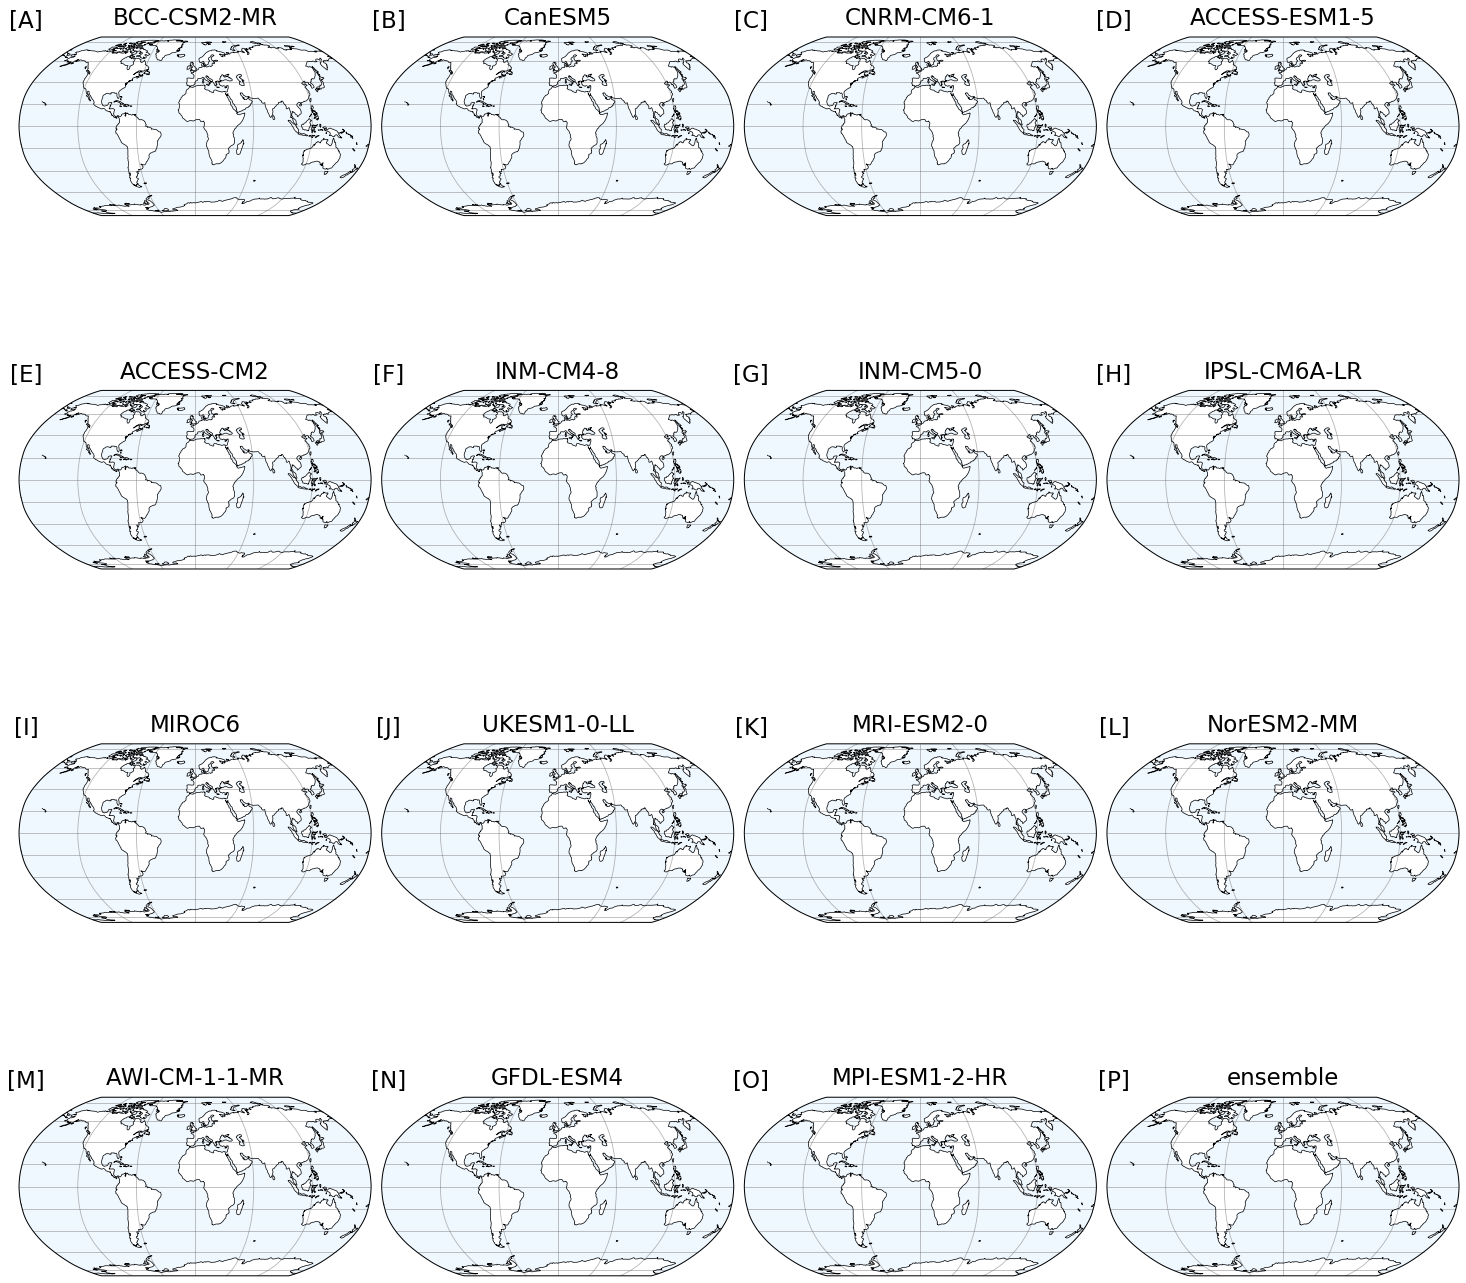

In [142]:
# define map projections and transformations
projection = ccrs.Robinson() # use Robinson projection
transform = ccrs.PlateCarree() # transform from PlateCarree projection

# define figure fontsizes
axis_title_fs = 24
plot_label_fs = 23
tick_label_fs = 23

# create figure and axes objects
fig, axes = plt.subplots(nrows = 4, ncols = 4, figsize = (20, 20),
                         subplot_kw = {'projection': projection})
axes = axes.flatten(order = 'C') # flatten to a 1D array

# create subplot bases
titles = list(rmse_dict.keys()) # define list of model names used
label = ['[A]', '[B]', '[C]', '[D]', '[E]', '[F]', '[G]', '[H]', '[I]', '[J]',
         '[K]', '[L]', '[M]', '[N]', '[O]', '[P]']
for i, axs in enumerate(axes):
    axs.coastlines(color = 'black', resolution = '110m', lw = 0.7, zorder = 2)
    axs.gridlines(color = 'dimgrey', alpha = 0.5, zorder = 2)
    axs.add_feature(cartopy.feature.OCEAN, facecolor = 'aliceblue', zorder = 1)
    axs.set_title(titles[i], fontsize = plot_label_fs, pad = 12)
    axs.text(x = 0.02, y = 1.05, s = label[i], fontsize = plot_label_fs, 
             horizontalalignment = 'center', transform = axs.transAxes)
    
# adjust position of subplots to make space for a colourbar and reduce whitespacing
fig.subplots_adjust(bottom = 0.03, top = 1, left = 0., right = 1., wspace = 0.03, hspace = 0.05)


########## model observational anomalies ###########

# define bounds to group data with; each bin will then be normalised and mapped to a specific colour
bnds1 = np.array([-750, -50, -45, -40, -35, -30, -25, -15, -10, -5, -1, -0,
                  1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 750]) # outer bounds for anomaly larger

# count number of negative and postive bound values
neg_bnds1 = sum(1 for i in bnds1 if i < 0)
pos_bnds1 = len(bnds1) - neg_bnds1

# create custom colourmap; obtain a list of RGB values for each colour to be mapped to
pos_colour_list1 = plt.cm.get_cmap('YlOrRd', pos_bnds1)
neg_colour_list1 = plt.cm.get_cmap('YlGnBu_r', neg_bnds1 + 1) # so can exclude additional colour to match 
colours1 = np.vstack((neg_colour_list1(np.arange(neg_bnds1 + 1))[: -1], # exclude additional colour
                      pos_colour_list1(np.arange(pos_bnds1))))
colours1 = list(colours1)

# create custom colourmap; set colours of values exceeding contour levels set
cmap1 = colors.ListedColormap(colours1[1 :-1], '') # create colourmap object from specified colours
cmap1.set_over(colours1[-1]) # set colour of values exceeding upper contour value
cmap1.set_under(colours1[0]) # set colours of values exceeding lower contour value
norm1 = colors.BoundaryNorm(boundaries = bnds1,
                            ncolors = len(bnds1) - 2, # colours available to map too; out of bounds do not count
                            clip = False) 

# define the levels/contours for the subplots
lvls1 = np.array([-50, -45, -40, -35, -30, -25, -15, -10, -5, -1, -0,
                  1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
    
